In [1]:
import numpy as np
import gpmp.num as gnp
import gpmp as gp
import matplotlib.pyplot as plt

Using backend: torch


# Parameters

In [2]:
f                   = gp.misc.testfunctions.twobumps
box                 = [[-1], [1]]
N_function_points   = 50
N_observed_points   = 10 
mu0                 = 0
p                   = 3
nugget              = 1e-8 
meanparam           = np.array([mu0])

# Functions

In [3]:
def generate_data(f, box, N_function_points, N_observed_points):
    input_dimension   = 1
    x_function_points = gp.misc.designs.regulargrid(input_dimension, N_function_points, box)
    y_function_points = f(x_function_points)
    x_observed_points = gp.misc.designs.ldrandunif(input_dimension, N_observed_points, box)
    y_observed_points = f(x_observed_points)
    return x_function_points, y_function_points, x_observed_points, y_observed_points

In [4]:
def constant_mean(x, meanparam):
    return meanparam[0] * gnp.ones((x.shape[0], 1))

In [5]:
def kernel(x, y, covparam, pairwise=False):
    return gp.kernel.maternp_covariance(x, y, p, covparam, pairwise, nugget)

In [6]:
def visualize_results(x_function_points, y_function_points, x_observed_points, y_observed_points, y_posterior_mean, y_posterior_variance):
    fig = gp.misc.plotutils.Figure(isinteractive=True)
    fig.plot                      (x_function_points, y_function_points, 'k', linewidth=1, linestyle=(0, (5, 5)))
    fig.plotdata                  (x_observed_points, y_observed_points)
    fig.plotgp                    (x_function_points, y_posterior_mean, y_posterior_variance, colorscheme='simple')
    fig.xylabels                  ('$x$', '$z$')
    fig.title                     ('Posterior GP with parameters selected by ReML')
    fig.show                      (grid=True, xlim=[-1.0, 1.0], legend=True, legend_fontsize=9)

# Points generation

In [7]:
x_function_points, y_function_points, x_observed_points, y_observed_points = generate_data(f, box, N_function_points, N_observed_points)

# Gaussian process 1D regression with GPMP

In [8]:
model                                  = gp.core.Model(constant_mean, kernel, meanparam, meantype="parameterized")
model, info                            = gp.kernel.select_parameters_with_reml(model, x_observed_points, y_observed_points, info=True)
covparam0                              = gp.kernel.anisotropic_parameters_initial_guess(model, x_observed_points, y_observed_points)
nlrl, dnlrl                            = gp.kernel.make_selection_criterion_with_gradient(model.negative_log_likelihood_zero_mean, x_observed_points, y_observed_points)
covparam_reml, info2                   = gp.kernel.autoselect_parameters(covparam0, nlrl, dnlrl, info=True)
model.covparam                         = gnp.asarray(covparam_reml)
y_posterior_mean, y_posterior_variance = model.predict(x_observed_points, y_observed_points, x_function_points)

In [9]:
print(np.exp(0.5*covparam_reml[0]), np.exp(-covparam_reml[1]))

1.1140833772662972 0.6834648992237727


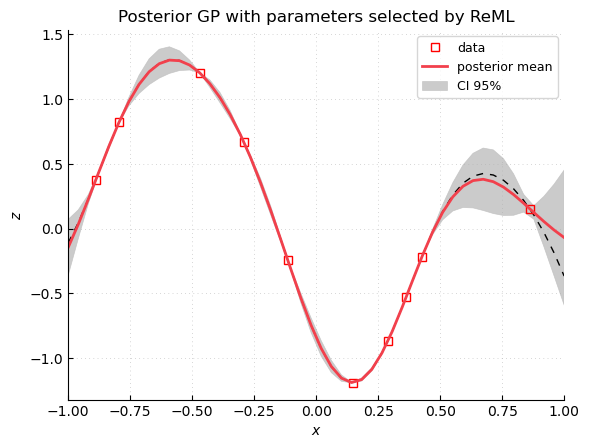

In [10]:
visualize_results(x_function_points, y_function_points, x_observed_points, y_observed_points, y_posterior_mean, y_posterior_variance)

# Gaussian process 1D regression with custom class

In [11]:
import sys 
sys.path.append("C:/Users/L2S/Desktop/Efficient_and_reliable_GP/")

from Code.gaussian_processes.gaussian_process            import GaussianProcessModel
from Code.Parameters        .gaussian_process_parameters import gaussian_process_model_parameters

In [12]:
gaussian_process_model_parameters["Mean initialization method"] = "Fixed"
gaussian_process_model_parameters["Default mean parameter"    ] = mu0
gaussian_process_model_parameters["Nugget"                    ] = nugget
gaussian_process_model_parameters["Matern parameter"          ] = p

In [13]:
gaussian_process_model                 = GaussianProcessModel(x_observed_points, y_observed_points, gaussian_process_model_parameters)
gaussian_process_model.train()
hyperparameters                        = gaussian_process_model.get_hyperparameters() 
y_posterior_mean, y_posterior_variance = gaussian_process_model.predict(x_function_points)

In [14]:
hyperparameters

{'Time': 0.054962873458862305,
 'p': 3,
 'mu': 0,
 'sigma': 1.1140380705158301,
 'Length scales': [0.683449107111571],
 'Nugget': 1e-08}

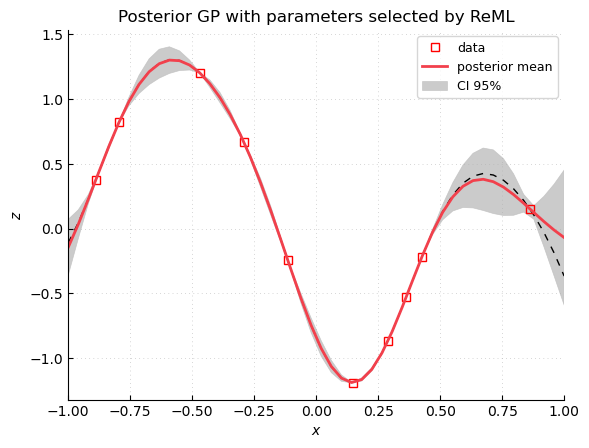

In [15]:
visualize_results(x_function_points, y_function_points, x_observed_points, y_observed_points, y_posterior_mean, y_posterior_variance)